I am trying to answer this Metaculus question:

[What fraction of the US Congress will be held by women following the election on November 3, 2020?](https://www.metaculus.com/questions/4661/what-fraction-of-the-us-congress-will-be-held-by-women-following-the-election-on-november-3-2020/)

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = np.array([16, 9]) * .8
plt.rcParams['font.size'] = 22

import seaborn as sns

from gender_guesser.detector import Detector as GenderDetector

# some hardcoded stuff
# there are 33 class 2 seats up for regular election
# plus 2 class 3 seats up for special elections following death (1) and resignation (1)
# out of the 33 class 1 + (34-2) class 2 = 65 seats not up for election, I count
# 11 class 1 women won in 2018
# 6 class 2 women won in 2016
sure_women = 11 + 6
sure_men = 65 - sure_women

Load data

In [72]:
def load_data(chamber, model, date='today'):
    if chamber == "senate":
        chamber += "_state"
    elif chamber == "house":
        chamber += "_district"
    else:
        raise ValueError(f"{chamber} not a valid chamber")

    fpath = f"538/{chamber}_toplines_2020.csv"
    
    df = pd.read_csv(fpath)
    df.forecastdate = pd.to_datetime(df.forecastdate)

    df = df[
        (df.forecastdate.apply(lambda d: d.date()) == pd.to_datetime(date).date()) &\
        (df.expression == model)
    ]

    return df

def draw(df, size=int(1e4)):
    """
    Draw `size` elections using the probabilities in `df`. This function assumes the dataframe `df` contains *only one row per race*.
    """

    ret = []
    labels = [f'{p}{n}' for p in ('D', 'R') for n in (1,2,3,4)] + ['I1', 'O1']

    for idx, district in df.iterrows():
        candidates = district[['name_' + label for label in labels]].values
        probs = district[['winner_' + label for label in labels]].values.astype(float)
        try:
            ret.append(np.random.choice(candidates, size=size, replace=True, p=probs))
        except ValueError as e:
            print(f"In the {district['branch']} race in {district['district']}, probabilities sum up to {probs.sum()} and had to be renormalized")
            ret.append(np.random.choice(candidates, size=size, replace=True, p=probs/probs.sum()))
    
    return pd.DataFrame(ret).T

def genderize(names, gender_tag_to_weight=None, verbose=False):
    """
    Map a list of names to a dict {name: gender}.
    """

    get_gender = GenderDetector().get_gender
    g_dict = {}

    for i, name in enumerate(names):
        q = get_gender(name.split()[0]) # 1st name only
        g_dict[name] = q if gender_tag_to_weight is None else gender_tag_to_weight[q]

        if verbose:
            print(f"{name}... {i+1} of {len(names)}")
            print(f"Result: {q}")
            print()

    return g_dict

In [73]:
model = "_deluxe"
h = load_data("house", model=model)
s = load_data("senate", model=model)
c = pd.concat([h, s], axis=0)

Run simulations

In [74]:
draws = draw(c, size=int(1e4))
all_candidates = np.unique(draws.values.flatten(), return_index=False, return_inverse=False, return_counts=False)

In the House race in CA-10, probabilities sum up to 0.999975 and had to be renormalized


Get genders

In [95]:
# how each gender tag should be weighted in the spectrum
# 1 = female
# 0 = male
gender_tag_to_weight = {
    'female': 1,
    'mostly_female': 1,
    'male': 0,
    'mostly_male': 0,
    'unknown': .5,
    'andy': .5
}

g_dict = genderize(all_candidates) #, gender_tag_to_weight=gender_tag_to_weight)
g = draws.applymap(lambda name: g_dict[name]).apply(lambda r: r.value_counts(), axis=1)
# n_women = draws.applymap(lambda name: g_dict[name]).sum(axis=1)
# print('Percentage of women:')
# print(n_women.describe())
# _ = sns.kdeplot(n_women)

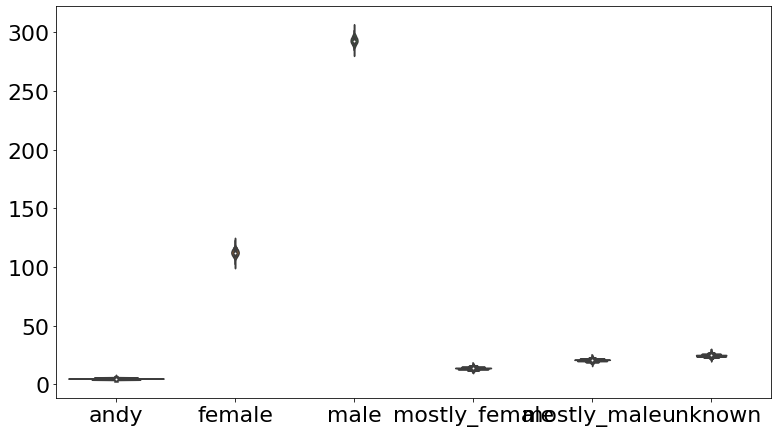

In [96]:
sns.violinplot(data=g)

In [97]:
g.describe()

,andy,female,male,mostly_female,mostly_male,unknown
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.010300,112.478300,293.189100,13.859300,20.773800,24.689200
std,0.741922,3.008228,3.213094,1.236065,1.225554,1.303523
min,4.000000,100.000000,281.000000,10.000000,16.000000,20.000000
25%,4.000000,110.000000,291.000000,13.000000,20.000000,24.000000
50%,5.000000,112.000000,293.000000,14.000000,21.000000,25.000000
75%,5.000000,115.000000,295.000000,15.000000,22.000000,26.000000
max,8.000000,124.000000,306.000000,18.000000,25.000000,30.000000


In [98]:
_g = g.copy(deep=True)
_g.female += sure_women
_g.male += sure_men

In [99]:
_g.describe()

,andy,female,male,mostly_female,mostly_male,unknown
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.010300,129.478300,341.189100,13.859300,20.773800,24.689200
std,0.741922,3.008228,3.213094,1.236065,1.225554,1.303523
min,4.000000,117.000000,329.000000,10.000000,16.000000,20.000000
25%,4.000000,127.000000,339.000000,13.000000,20.000000,24.000000
50%,5.000000,129.000000,341.000000,14.000000,21.000000,25.000000
75%,5.000000,132.000000,343.000000,15.000000,22.000000,26.000000
max,8.000000,141.000000,354.000000,18.000000,25.000000,30.000000


In [102]:
__g = _g.copy()
__g.female += __g.mostly_female + __g.unknown/2 + __g.andy/2
__g.describe()

,andy,female,male,mostly_female,mostly_male,unknown
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.010300,158.187350,341.189100,13.859300,20.773800,24.689200
std,0.741922,3.047975,3.213094,1.236065,1.225554,1.303523
min,4.000000,147.000000,329.000000,10.000000,16.000000,20.000000
25%,4.000000,156.000000,339.000000,13.000000,20.000000,24.000000
50%,5.000000,158.000000,341.000000,14.000000,21.000000,25.000000
75%,5.000000,160.000000,343.000000,15.000000,22.000000,26.000000
max,8.000000,170.500000,354.000000,18.000000,25.000000,30.000000


In [103]:
100 * np.array([156, 158, 160]) / (100 + h.shape[0])

array([29.1588785 , 29.53271028, 29.90654206])

In [107]:
[k for k in g_dict if g_dict[k] == 'andy']

['Blair Walsingham',
 'Corky Messner',
 'Ike McCorkle',
 'Jackie Gordon',
 'Jackie Speier',
 'Jackie Walorski',
 'Jo Rae Perkins',
 'Kendall Qualls',
 'Pat Fallon',
 'Pat Hackett',
 'Ro Khanna',
 'Sri Preston Kulkarni']